## Using OpenForce toolkit to parameterize molecules

In [69]:
from openff.toolkit import Molecule, Topology, ForceField
from openff.interchange import Interchange
from openff.units import unit, Quantity
from openff.toolkit.utils.toolkits import NAGLToolkitWrapper
import numpy as np

Define a molecule via SMILES 1D representation

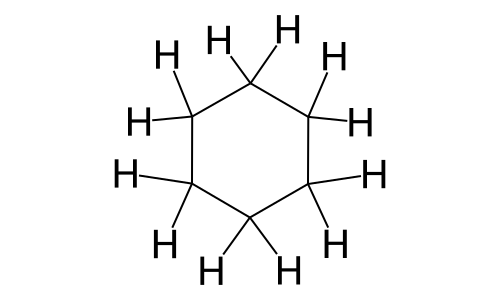

In [70]:
mol_smiles = "C1CCCCC1" # cyclohexane

monomer = Molecule.from_smiles(mol_smiles) 
monomer.visualize()

In [71]:
# assign a force field
sage = ForceField("openff-2.2.0.offxml")
# big box
cubic_box = unit.Quantity(50 * np.eye(3), unit.angstrom)

In [72]:
# use RDkit to generate a conformer
monomer.generate_conformers(n_conformers=1)

# create the internal representation
topology = Topology.from_molecules(monomer)

# create the interchange object. Note- is parameterizing with AM1-BCC
solute_interchange = Interchange.from_smirnoff(topology=[monomer], 
                                                   force_field=sage, box = cubic_box)

# approximately minimize energy with OpenMM
solute_interchange.minimize()

In [94]:
# lammps files
solute_interchange.to_lammps('monomer.lmp')

# gromacs files
solute_interchange.to_gro('monomer.gro')
solute_interchange.to_top('monomer.top')

# amber files
solute_interchange.to_prmtop('monomer.prmtop') 
solute_interchange.to_inpcrd("monomer.inpcrd")

### Version that packs a box with the designated molecule.

In [74]:
from openff.interchange.components._packmol import pack_box

In [75]:
n_solute = 200
#Define the box
# this box may be too big, will need to be equilibrated
cubic_box = unit.Quantity(35 * np.eye(3), unit.angstrom)

monomer.generate_conformers(n_conformers=1) 
# above generates a single conformation, could potentially make a more complicated version
# with multiple configurations?

packed_topology = pack_box(
        molecules=[monomer],
        number_of_copies=[n_solute],
        solute=None,
        tolerance=1.0*unit.angstrom,
        box_vectors=cubic_box,
    )

In [76]:
packed_interchange = Interchange.from_smirnoff(
            force_field=ForceField("openff-2.2.0.offxml"),
            topology=packed_topology, box=cubic_box)

In [77]:
# Minimize with OpenMM
packed_interchange.minimize()

In [78]:
# create lammps files
packed_interchange.to_lammps('monomer_packed.lmp')

# create gromacs files
packed_interchange.to_gro('monomer_packed.gro')
packed_interchange.to_top('monomer_packed.top')

# create amber files
packed_interchange.to_prmtop('monomer_packed.prmtop') 
packed_interchange.to_inpcrd("monomer_packed.inpcrd")

### Solvating the molecule in water

In [79]:
# Construct a water molecule
water = Molecule.from_smiles("O")
water.generate_conformers(n_conformers=1)

In [80]:
# Pack the box with an arbitrary number of water around the solute.

cubic_box = unit.Quantity(30 * np.eye(3), unit.angstrom)
n_water = 900

from openff.interchange.components._packmol import pack_box
packed_topology = pack_box(
    molecules=[water],
    number_of_copies=[n_water],
    solute=Topology.from_molecules(monomer),
    tolerance=0.5*unit.angstrom,
    box_vectors=cubic_box,
)

In [81]:
solvated_interchange = Interchange.from_smirnoff(
    force_field=ForceField("openff-2.2.0.offxml","opc3.offxml"),
    topology=packed_topology,
    box=cubic_box
)

In [82]:
# approximately minimize energy with OpenMM
solute_interchange.minimize()

In [83]:
# lammps files
solvated_interchange.to_lammps('solvated_molecule.lmp')

In [84]:
# gromacs files
solvated_interchange.to_gro('solvated_molecule.gro')
solvated_interchange.to_top('solvated_molecule.top')

In [85]:
# for kicks, amber files
solvated_interchange.to_prmtop('solvated_molecule.prmtop') 
solvated_interchange.to_inpcrd("solvated_molecule.inpcrd")

### Creating a mixture

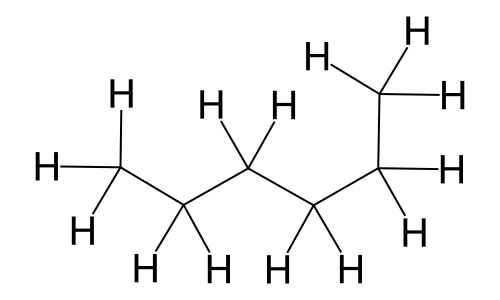

In [86]:
monomer2 = Molecule.from_smiles("CCCCCC")
monomer2.generate_conformers(n_conformers=1)
monomer2.visualize()
# use RDkit to generate a conformer


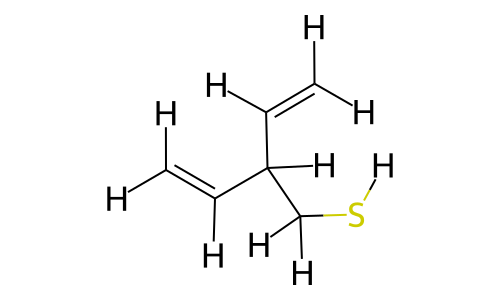

In [87]:
monomer3 = Molecule.from_smiles("C=CC(CS)C=C")
monomer3.generate_conformers(n_conformers=1)
monomer3.visualize()

In [88]:
# Pack the box with all three solutes

# box is probably too big
cubic_box = unit.Quantity(40 * np.eye(3), unit.angstrom)
n_monomer = 100
n_monomer2 = 100
n_monomer3 = 100

from openff.interchange.components._packmol import pack_box
packed_mixture_topology = pack_box(
    molecules=[monomer,monomer2,monomer3],
    number_of_copies=[n_monomer,n_monomer2,n_monomer3],
    solute=None,
    tolerance=1.0*unit.angstrom,
    box_vectors=cubic_box,
)

In [89]:
mixture_interchange = Interchange.from_smirnoff(
    force_field=ForceField("openff-2.2.0.offxml","opc3.offxml"),
    topology=packed_mixture_topology,
    box=cubic_box
)

In [90]:
# approximately minimize energy with OpenMM
mixture_interchange.minimize()

In [91]:
# lammps files
mixture_interchange.to_lammps('mixture.lmp')

In [92]:
# gromacs files
mixture_interchange.to_gro('mixture.gro')
solvated_interchange.to_top('mixture.top')

In [93]:
# for kicks, amber files
mixture_interchange.to_prmtop('mixture.prmtop') 
mixture_interchange.to_inpcrd("mixture.inpcrd")